#### These below steps are supposed to be executed only in google colab:
They will install libraries on the fly. However in jupyter notebook you have to preinstall required libraries using 'cmd' prompt

- !pip install -q pyomo
- !apt-get install -y -qq coinor-cbc
- !apt-get install -y -qq glpk-utils

In [1]:
# Importing Libraries 

import pandas as pd
import numpy as np
import math
from pyomo.environ import *

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from __future__ import division
from pyomo.opt import SolverFactory

#### Link to use relative path to input data set based on your directory structure:
https://stackoverflow.com/questions/50119792/python-import-excel-file-using-relative-path

In [3]:
# Reading the data from Excel workbook
# inputdata='Staffing+Data.xlsx'
inputdata=r'./../data/raw/Staffing+Data.xlsx'
AppDemand = pd.read_excel(inputdata, sheet_name='DemandData')
StaffAv = pd.read_excel(inputdata, sheet_name='StaffAvailability')
Cost = pd.read_excel(inputdata, sheet_name='Cost')
ServiceRate = pd.read_excel(inputdata, sheet_name='ServiceRate')


In [4]:
print(AppDemand.shape)
AppDemand.head()

(36, 3)


,State,Month,Demand
0,A,Jan,5240
1,A,Feb,4878
2,A,Mar,5942
3,A,Apr,2297
4,A,May,1992


In [5]:
print(StaffAv.shape)
StaffAv.head()

(36, 5)


,State,Month,LB,UB,StaffAvPer
0,A,Jan,0.70,0.90,0.81
1,A,Feb,0.65,0.85,0.76
2,A,Mar,0.70,0.80,0.75
3,A,Apr,0.75,0.85,0.80
4,A,May,0.70,0.85,0.78


In [6]:
print(Cost.shape)
Cost.head()

(36, 5)


,State,Month,AnnualSalary,MonthlySalary,UnitOutSourceCost
0,A,Jan,60000,5000.0,180
1,A,Feb,60000,5000.0,180
2,A,Mar,60000,5000.0,180
3,A,Apr,60000,5000.0,180
4,A,May,60000,5000.0,180


In [7]:
print(ServiceRate.shape)
ServiceRate.head()

(1, 1)


,MgAppServedPerMonth
0,40


## Data pre-processing 

#### Create the required Python data structures for indexes and parameters


In [8]:
# Demand data
Demand = AppDemand.set_index(['State', 'Month'])['Demand'].to_dict()
Demand

{('A', 'Jan'): 5240,
 ('A', 'Feb'): 4878,
 ('A', 'Mar'): 5942,
 ('A', 'Apr'): 2297,
 ('A', 'May'): 1992,
 ('A', 'Jun'): 2275,
 ('A', 'Jul'): 5334,
 ('A', 'Aug'): 3371,
 ('A', 'Sep'): 3759,
 ('A', 'Oct'): 3529,
 ('A', 'Nov'): 4284,
 ('A', 'Dec'): 5183,
 ('B', 'Jan'): 4927,
 ('B', 'Feb'): 2628,
 ('B', 'Mar'): 2974,
 ('B', 'Apr'): 2338,
 ('B', 'May'): 4020,
 ('B', 'Jun'): 3147,
 ('B', 'Jul'): 4271,
 ('B', 'Aug'): 2620,
 ('B', 'Sep'): 4517,
 ('B', 'Oct'): 4155,
 ('B', 'Nov'): 3137,
 ('B', 'Dec'): 4227,
 ('C', 'Jan'): 1162,
 ('C', 'Feb'): 1967,
 ('C', 'Mar'): 1898,
 ('C', 'Apr'): 2261,
 ('C', 'May'): 2030,
 ('C', 'Jun'): 1642,
 ('C', 'Jul'): 2489,
 ('C', 'Aug'): 2496,
 ('C', 'Sep'): 922,
 ('C', 'Oct'): 2421,
 ('C', 'Nov'): 963,
 ('C', 'Dec'): 1998}

In [9]:
# FTE Salary from the data
FTE_Salary = Cost.set_index(['State', 'Month'])['MonthlySalary'].to_dict()
FTE_Salary

{('A', 'Jan'): 5000.0,
 ('A', 'Feb'): 5000.0,
 ('A', 'Mar'): 5000.0,
 ('A', 'Apr'): 5000.0,
 ('A', 'May'): 5000.0,
 ('A', 'Jun'): 5000.0,
 ('A', 'Jul'): 5000.0,
 ('A', 'Aug'): 5000.0,
 ('A', 'Sep'): 5000.0,
 ('A', 'Oct'): 5000.0,
 ('A', 'Nov'): 5000.0,
 ('A', 'Dec'): 5000.0,
 ('B', 'Jan'): 4583.333333333333,
 ('B', 'Feb'): 4583.333333333333,
 ('B', 'Mar'): 4583.333333333333,
 ('B', 'Apr'): 4583.333333333333,
 ('B', 'May'): 4583.333333333333,
 ('B', 'Jun'): 4583.333333333333,
 ('B', 'Jul'): 4583.333333333333,
 ('B', 'Aug'): 4583.333333333333,
 ('B', 'Sep'): 4583.333333333333,
 ('B', 'Oct'): 4583.333333333333,
 ('B', 'Nov'): 4583.333333333333,
 ('B', 'Dec'): 4583.333333333333,
 ('C', 'Jan'): 4416.666666666667,
 ('C', 'Feb'): 4416.666666666667,
 ('C', 'Mar'): 4416.666666666667,
 ('C', 'Apr'): 4416.666666666667,
 ('C', 'May'): 4416.666666666667,
 ('C', 'Jun'): 4416.666666666667,
 ('C', 'Jul'): 4416.666666666667,
 ('C', 'Aug'): 4416.666666666667,
 ('C', 'Sep'): 4416.666666666667,
 ('C', 'Oc

In [10]:
# Unit outsourcing Cost
UnitOutSourceCost = Cost.set_index(['State', 'Month'])['UnitOutSourceCost'].to_dict()
UnitOutSourceCost

{('A', 'Jan'): 180,
 ('A', 'Feb'): 180,
 ('A', 'Mar'): 180,
 ('A', 'Apr'): 180,
 ('A', 'May'): 180,
 ('A', 'Jun'): 180,
 ('A', 'Jul'): 180,
 ('A', 'Aug'): 180,
 ('A', 'Sep'): 180,
 ('A', 'Oct'): 180,
 ('A', 'Nov'): 180,
 ('A', 'Dec'): 180,
 ('B', 'Jan'): 150,
 ('B', 'Feb'): 150,
 ('B', 'Mar'): 150,
 ('B', 'Apr'): 150,
 ('B', 'May'): 150,
 ('B', 'Jun'): 150,
 ('B', 'Jul'): 150,
 ('B', 'Aug'): 150,
 ('B', 'Sep'): 150,
 ('B', 'Oct'): 150,
 ('B', 'Nov'): 150,
 ('B', 'Dec'): 150,
 ('C', 'Jan'): 160,
 ('C', 'Feb'): 160,
 ('C', 'Mar'): 160,
 ('C', 'Apr'): 160,
 ('C', 'May'): 160,
 ('C', 'Jun'): 160,
 ('C', 'Jul'): 160,
 ('C', 'Aug'): 160,
 ('C', 'Sep'): 160,
 ('C', 'Oct'): 160,
 ('C', 'Nov'): 160,
 ('C', 'Dec'): 160}

In [11]:
# Number of Applications when Employee working Full Time
FTE_AppServiceRate = ServiceRate.iloc[0,0]
FTE_AppServiceRate

40

In [12]:
StaffAv.head()

,State,Month,LB,UB,StaffAvPer
0,A,Jan,0.70,0.90,0.81
1,A,Feb,0.65,0.85,0.76
2,A,Mar,0.70,0.80,0.75
3,A,Apr,0.75,0.85,0.80
4,A,May,0.70,0.85,0.78


In [13]:
# Staff Availability for serving the Insurance Applications
# Worst and Best => staffavail_LB and staffavail_UB respectively

StaffAv_LB = StaffAv.set_index(['State', 'Month'])['LB'].to_dict()
StaffAv_UB = StaffAv.set_index(['State', 'Month'])['UB'].to_dict()
StaffAv_Per = StaffAv.set_index(['State', 'Month'])['StaffAvPer'].to_dict()

In [14]:
StaffAv_LB

{('A', 'Jan'): 0.7,
 ('A', 'Feb'): 0.65,
 ('A', 'Mar'): 0.7,
 ('A', 'Apr'): 0.75,
 ('A', 'May'): 0.7,
 ('A', 'Jun'): 0.65,
 ('A', 'Jul'): 0.6,
 ('A', 'Aug'): 0.65,
 ('A', 'Sep'): 0.7,
 ('A', 'Oct'): 0.65,
 ('A', 'Nov'): 0.6,
 ('A', 'Dec'): 0.6,
 ('B', 'Jan'): 0.7,
 ('B', 'Feb'): 0.65,
 ('B', 'Mar'): 0.7,
 ('B', 'Apr'): 0.75,
 ('B', 'May'): 0.7,
 ('B', 'Jun'): 0.65,
 ('B', 'Jul'): 0.6,
 ('B', 'Aug'): 0.65,
 ('B', 'Sep'): 0.7,
 ('B', 'Oct'): 0.65,
 ('B', 'Nov'): 0.6,
 ('B', 'Dec'): 0.6,
 ('C', 'Jan'): 0.7,
 ('C', 'Feb'): 0.65,
 ('C', 'Mar'): 0.7,
 ('C', 'Apr'): 0.75,
 ('C', 'May'): 0.7,
 ('C', 'Jun'): 0.65,
 ('C', 'Jul'): 0.6,
 ('C', 'Aug'): 0.65,
 ('C', 'Sep'): 0.7,
 ('C', 'Oct'): 0.65,
 ('C', 'Nov'): 0.6,
 ('C', 'Dec'): 0.6}

In [15]:
StaffAv_UB

{('A', 'Jan'): 0.9,
 ('A', 'Feb'): 0.85,
 ('A', 'Mar'): 0.8,
 ('A', 'Apr'): 0.85,
 ('A', 'May'): 0.85,
 ('A', 'Jun'): 0.8,
 ('A', 'Jul'): 0.75,
 ('A', 'Aug'): 0.85,
 ('A', 'Sep'): 0.9,
 ('A', 'Oct'): 0.8,
 ('A', 'Nov'): 0.75,
 ('A', 'Dec'): 0.7,
 ('B', 'Jan'): 0.9,
 ('B', 'Feb'): 0.85,
 ('B', 'Mar'): 0.8,
 ('B', 'Apr'): 0.85,
 ('B', 'May'): 0.85,
 ('B', 'Jun'): 0.8,
 ('B', 'Jul'): 0.75,
 ('B', 'Aug'): 0.85,
 ('B', 'Sep'): 0.9,
 ('B', 'Oct'): 0.8,
 ('B', 'Nov'): 0.75,
 ('B', 'Dec'): 0.7,
 ('C', 'Jan'): 0.9,
 ('C', 'Feb'): 0.85,
 ('C', 'Mar'): 0.8,
 ('C', 'Apr'): 0.85,
 ('C', 'May'): 0.85,
 ('C', 'Jun'): 0.8,
 ('C', 'Jul'): 0.75,
 ('C', 'Aug'): 0.85,
 ('C', 'Sep'): 0.9,
 ('C', 'Oct'): 0.8,
 ('C', 'Nov'): 0.75,
 ('C', 'Dec'): 0.7}

In [16]:
StaffAv_Per

{('A', 'Jan'): 0.81,
 ('A', 'Feb'): 0.76,
 ('A', 'Mar'): 0.75,
 ('A', 'Apr'): 0.8,
 ('A', 'May'): 0.78,
 ('A', 'Jun'): 0.73,
 ('A', 'Jul'): 0.68,
 ('A', 'Aug'): 0.76,
 ('A', 'Sep'): 0.81,
 ('A', 'Oct'): 0.73,
 ('A', 'Nov'): 0.68,
 ('A', 'Dec'): 0.65,
 ('B', 'Jan'): 0.81,
 ('B', 'Feb'): 0.76,
 ('B', 'Mar'): 0.75,
 ('B', 'Apr'): 0.8,
 ('B', 'May'): 0.78,
 ('B', 'Jun'): 0.73,
 ('B', 'Jul'): 0.68,
 ('B', 'Aug'): 0.76,
 ('B', 'Sep'): 0.81,
 ('B', 'Oct'): 0.73,
 ('B', 'Nov'): 0.68,
 ('B', 'Dec'): 0.65,
 ('C', 'Jan'): 0.81,
 ('C', 'Feb'): 0.76,
 ('C', 'Mar'): 0.75,
 ('C', 'Apr'): 0.8,
 ('C', 'May'): 0.78,
 ('C', 'Jun'): 0.73,
 ('C', 'Jul'): 0.68,
 ('C', 'Aug'): 0.76,
 ('C', 'Sep'): 0.81,
 ('C', 'Oct'): 0.73,
 ('C', 'Nov'): 0.68,
 ('C', 'Dec'): 0.65}

In [17]:
Cost.head(1)

,State,Month,AnnualSalary,MonthlySalary,UnitOutSourceCost
0,A,Jan,60000,5000.0,180


In [18]:
Cost.State.unique()

array(['A', 'B', 'C'], dtype=object)

In [19]:
Cost.State.value_counts()

A    12
B    12
C    12
Name: State, dtype: int64

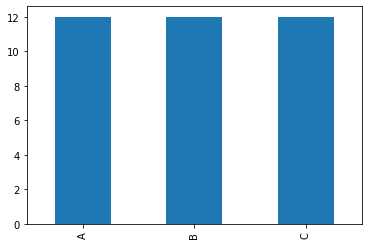

In [20]:
Cost.State.value_counts().plot.bar()
plt.show()

In [21]:
Cost.Month.unique()

array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
       'Oct', 'Nov', 'Dec'], dtype=object)

In [22]:
Cost.Month.value_counts()

Aug    3
Mar    3
Apr    3
Dec    3
May    3
Feb    3
Jun    3
Nov    3
Oct    3
Jan    3
Jul    3
Sep    3
Name: Month, dtype: int64

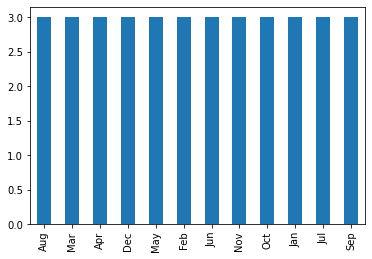

In [23]:
Cost.Month.value_counts().plot.bar()
plt.show()

In [24]:
# Index
BankLoc = Cost['State'].unique().tolist() #Directly convert array object to a list here
Month = Cost['Month'].unique().tolist() #Directly convert array object to a list here

In [25]:
#BankLoc
#array(['A', 'B', 'C'], dtype=object)
BankLoc

['A', 'B', 'C']

In [26]:
# Month = array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
#        'Oct', 'Nov', 'Dec'], dtype=object)
Month

['Jan',
 'Feb',
 'Mar',
 'Apr',
 'May',
 'Jun',
 'Jul',
 'Aug',
 'Sep',
 'Oct',
 'Nov',
 'Dec']

--------------------------

# In the Above Steps(Cells) we completed reading necessary Data into Python. 

# We next formulate pyomo model using "glpk solver" for our optimization process.

# Question 1

The company wants to know the optimised staffing recommendations for the business case described. 
Write the mathematical model for the deterministic optimisation problem. Define and explain your decision variables, objective function and the constraint. (Hint: Use months of the year as the model timeline).



**Note:** You can write the mathematical formulation directly in your report.

# Question 2

Code the problem is Python and use any optimization package to solve it. Add comments to your code to explain each step. 

#### Expected output:

Create a data frame containing the number of outsourced applications  and the number of FTEs for each state-month combination. You can choose to have extra columns like staff availability, demand etc. in your dataframe apart from the ones mentioned earlier. 

#### Creating a model instance

In [27]:
# model object
model = ConcreteModel()

# Next task is to define the Sets
model.i = Set(initialize = BankLoc, doc = 'State') # i is Insurance Company location
model.j = Set(initialize = Month, doc = 'Month') # j is Months

#### Define Pyomo sets and Parameters

In [28]:
# Parameters -> demand, FTE Salaries, Outsourcing Cost(oc), Average Staff Availability(sa)
model.d = Param(model.i, model.j, initialize = Demand, doc = 'Demand')
model.s = Param(model.i, model.j, initialize = FTE_Salary, doc = 'FTE_Salary')
model.oc = Param(model.i, model.j, initialize = UnitOutSourceCost, doc = 'UnitOutSourceCost')

model.saP = Param(model.i, model.j, initialize = StaffAv_Per, doc = 'StaffAvPer') #model.saP= Staff Availibility Percentage
model.saLB = Param(model.i, model.j, initialize = StaffAv_LB, doc = 'StaffAvLB') #model.saLB=Staff Availibility Lower Bound Percentage
model.saUB = Param(model.i, model.j, initialize = StaffAv_UB, doc = 'StaffAvUB') #modelsaUB=Staff Availibility Upper Bound Percentage

In [29]:
# Scaler Application Serve Rate when working 100%
model.r = Param(initialize = FTE_AppServiceRate, doc = 'FTE App Serve Rate')

In [30]:
model.r

In [31]:
# Parameter for no of Applications that can be processed for the given Staff Availability 

def c_FTEAPP(model, i, j):
    return model.r * model.saP[i,j]

model.FTEAPPNO = Param(model.i, model.j, initialize=c_FTEAPP, doc='No of FTE App')

In [32]:
model.FTEAPPNO

#### Decision variables

In [33]:
# Define Decision Variables
#X=App Quantity processed by internal full time staff. This is continuous variable
#y=App Quantity processed by outsourced vendors. This is Integer variable
model.x = Var(model.i, model.j, domain = NonNegativeReals, doc='No of FTE') #Continuous Variable
model.y = Var(model.i, model.j, domain = NonNegativeIntegers, doc='No of Outsourced Applications') #Integer Variable

### Constraints

#### Mathematical Expressions for Regulatory Constraints:
- Regulatory Constraint:y(i,j)<=Demand(i,j)*30 | For all i belongs to State 'A' and j belongs to all months(Jan to Dec)
- Regulatory Constraint: y(i,j)<=Demand(i,j)*40 | For all i belongs to State 'B' and j belongs to all months(Jan to Dec)

In [34]:
# Regulatory Constraint:y(i,j)<=Demand(i,j)*30 | For all i belongs to State 'A' and j belongs to all months(Jan to Dec)
# A -> 30%

def Reg_A(model, i, j):
    return 0.30 * model.d[i,j]

model.Reg_A = Param(model.i, model.j, initialize=Reg_A, doc='RegRest_A')

In [35]:
# Regulatory Constraint: y(i,j)<=Demand(i,j)*40 | For all i belongs to State 'B' and j belongs to all months(Jan to Dec)
# B -> 40%

def Reg_B(model, i, j):
    return 0.40 * model.d[i,j]

model.Reg_B = Param(model.i, model.j, initialize=Reg_B, doc='RegRest_B')

In [36]:
model.i

#### Mathematical expression of Demand Constraint:
#### Demand Constraint= Staff availability*(40Apps/FTE)+Outsourced Insurance Apps Quantity=(Insurance Apps Demand/Month)

In [37]:
# Demand Constraint

model.demand_constraint = ConstraintList()
for i in model.i:
    for j in model.j:
        model.demand_constraint.add(expr= model.x[i,j]*model.FTEAPPNO[i,j] + model.y[i,j] == model.d[i,j])

In [38]:
# Regulatory Constraint

model.regulatoryCons = ConstraintList()
for i in model.i:
    for j in model.j:
        if i=='A':
            model.regulatoryCons.add(expr = model.y['A', j] <= model.Reg_A['A', j])
        elif i=='B':
            model.regulatoryCons.add(expr = model.y['B', j] <= model.Reg_B['B', j])

#### Mathematical Expression For Objective function:

- Objective Function:Minimize(Annual Total Cost of FTE+Annual Total Cost of Outsourced Insurance Application)
- Minimize($\sum_{i}$ $\sum_{j}$ X(i,j) * FTESalary(i,j) + $\sum_{i}$ $\sum_{j}$ Y(i,j) * UnitCost(i,j))

In [39]:
def objective_rule(model):
    return sum(model.s[i,j]*model.x[i,j] for i in model.i for j in model.j) +\
           sum(model.oc[i,j]*model.y[i,j] for i in model.i for j in model.j)

model.objective = Objective(rule = objective_rule, sense = minimize, doc = 'Define Objective Function')

#### Invoking the "glpk" solver:


In [40]:
result_cost = SolverFactory('glpk').solve(model)
result_cost.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 17962336.4487699
  Upper bound: 17962336.4487699
  Number of objectives: 1
  Number of constraints: 61
  Number of variables: 73
  Number of nonzeros: 97
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.05999183654785156
# ----------------------------------------------------------
#   Solution Information
# ------------

result_cost = SolverFactory('glpk').solve(model)

result_cost.write()
#### Above code throws following error when you do not take care of writing output in a different excel file and than saving the excelwriter instance:

ERROR: Solver (glpk) returned non-zero return code (1)
ERROR: Solver log: GLPSOL--GLPK LP/MIP Solver 5.0 Parameter(s) specified in
    the command line:
     --write C:\Users\THEHOM~1\AppData\Local\Temp\tmpannjzqj7.glpk.raw --wglp
     C:\Users\THEHOM~1\AppData\Local\Temp\tmp4ofd1y97.glpk.glp --cpxlp
     C:\Users\THEHOM~1\AppData\Local\Temp\tmpbh90rifx.pyomo.lp
    Reading problem data from
    'C:\Users\THEHOM~1\AppData\Local\Temp\tmpbh90rifx.pyomo.lp'...
    C:\Users\THEHOM~1\AppData\Local\Temp\tmpbh90rifx.pyomo.lp:5: constraints
    section missing CPLEX LP file processing error
---------------------------------------------------------------------------
ApplicationError                          Traceback (most recent call last)
<ipython-input-41-eafa0353ff6a> in <module>
----> 1 result_cost = SolverFactory('glpk').solve(model)
      2 result_cost.write()

D:\dev\anaconda_installation_folder\lib\site-packages\pyomo\opt\base\solvers.py in solve(self, *args, **kwds)
    593                 elif hasattr(_status, 'log') and _status.log:
    594                     logger.error("Solver log:\n" + str(_status.log))
--> 595                 raise ApplicationError(
    596                     "Solver (%s) did not exit normally" % self.name)
    597             solve_completion_time = time.time()

ApplicationError: Solver (glpk) did not exit normally

In [41]:
model.pprint()

15 Set Declarations
    FTEAPPNO_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :    i*j :   36 : {('A', 'Jan'), ('A', 'Feb'), ('A', 'Mar'), ('A', 'Apr'), ('A', 'May'), ('A', 'Jun'), ('A', 'Jul'), ('A', 'Aug'), ('A', 'Sep'), ('A', 'Oct'), ('A', 'Nov'), ('A', 'Dec'), ('B', 'Jan'), ('B', 'Feb'), ('B', 'Mar'), ('B', 'Apr'), ('B', 'May'), ('B', 'Jun'), ('B', 'Jul'), ('B', 'Aug'), ('B', 'Sep'), ('B', 'Oct'), ('B', 'Nov'), ('B', 'Dec'), ('C', 'Jan'), ('C', 'Feb'), ('C', 'Mar'), ('C', 'Apr'), ('C', 'May'), ('C', 'Jun'), ('C', 'Jul'), ('C', 'Aug'), ('C', 'Sep'), ('C', 'Oct'), ('C', 'Nov'), ('C', 'Dec')}
    Reg_A_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :    i*j :   36 : {('A', 'Jan'), ('A', 'Feb'), ('A', 'Mar'), ('A', 'Apr'), ('A', 'May'), ('A', 'Jun'), ('A', 'Jul'), ('A', 'Aug'), ('A', 'Sep'), ('A', 'Oct'), ('A', 'Nov'), ('A', 'Dec'), ('B', 'Jan'), ('B', 'Feb'), (

In [42]:
#model.value

In [43]:
#No of FTE for State 'A' 'Dec' month 
print(model.x['A','Jan'].value)
print(model.x['A','Dec'].value)  #Answer should be closer to 139

161.728395061728
139.576923076923


In [44]:
# The number of Applications processed by outsourced vendor
print(model.y['A', 'Jan'].value)
print(model.y['A', 'Dec'].value) #Answer should be closer to 1554

0.0
1554.0


#### Print the value of the objective function

In [45]:
TotalCost = model.objective.expr() #Answer should be closer to 18million
TotalCost

17962336.448769882

**`Checkpoint 1:`** Seems like the company has to spend around 17.9 m$ in total for the application approval process.

#### Creating dataframe for the results


In [46]:
# Create dataframe FTE_Staff containing our FTE and the number of applications outsourced and other columns of interest:

FTE_Staff = []
for i in BankLoc:
    for j in Month:
        demand=model.d[i,j]
        lb_per=model.saLB[i,j]
        ub_per=model.saUB[i,j]
        staffav_per=model.saP[i,j]
        fte=model.x[i,j].value #This is output given by the pyomo after solving the formulated model
        app_outsourced=model.y[i,j].value #This is output given by the pyomo after solving the formulated model
        
        app_staff_processed = model.x[i,j].value*40*model.saP[i,j]
        monthly_cost = model.x[i,j].value*FTE_Salary[i,j] + model.y[i,j].value*UnitOutSourceCost[i,j]
        percent_app_outsourced = round((app_outsourced/demand)*100,2)
        percent_app_staff_processed = round((app_staff_processed/demand)*100,2)
        avg_cost_per_app = monthly_cost/demand
        FTE_Staff.append([i,j,demand,lb_per,ub_per,staffav_per,fte,app_outsourced,app_staff_processed,percent_app_outsourced,percent_app_staff_processed,monthly_cost,avg_cost_per_app])  #list of list
        
FTE_Staff = pd.DataFrame(FTE_Staff, columns=['State','Month','Apps_Demand','LB_Per','UB_Per','StaffAvPer','FTE','App_Outsourced',"App_Staff_Processed" , 'Per_App_Outsourced', 'Per_App_Staff_Processed','Monthly_Cost','Avg_Cost_Per_App'])

In [47]:
FTE_Staff.head(10)

,State,Month,Apps_Demand,LB_Per,UB_Per,StaffAvPer,FTE,App_Outsourced,App_Staff_Processed,Per_App_Outsourced,Per_App_Staff_Processed,Monthly_Cost,Avg_Cost_Per_App
0,A,Jan,5240,0.70,0.90,0.81,161.728395,0.0,5240.0,0.0,100.0,808641.975309,154.320988
1,A,Feb,4878,0.65,0.85,0.76,160.460526,0.0,4878.0,0.0,100.0,802302.631579,164.473684
2,A,Mar,5942,0.70,0.80,0.75,198.066667,0.0,5942.0,0.0,100.0,990333.333333,166.666667
3,A,Apr,2297,0.75,0.85,0.80,71.781250,0.0,2297.0,0.0,100.0,358906.250000,156.250000
4,A,May,1992,0.70,0.85,0.78,63.846154,0.0,1992.0,0.0,100.0,319230.769231,160.256410
5,A,Jun,2275,0.65,0.80,0.73,77.910959,0.0,2275.0,0.0,100.0,389554.794521,171.232877
6,A,Jul,5334,0.60,0.75,0.68,137.279412,1600.0,3734.0,30.0,70.0,974397.058824,182.676614
7,A,Aug,3371,0.65,0.85,0.76,110.888158,0.0,3371.0,0.0,100.0,554440.789474,164.473684
8,A,Sep,3759,0.70,0.90,0.81,116.018519,0.0,3759.0,0.0,100.0,580092.592593,154.320988
9,A,Oct,3529,0.65,0.80,0.73,120.856164,0.0,3529.0,0.0,100.0,604280.821918,171.232877


In [48]:
# What is the average FTE per Month

TotalFTE = FTE_Staff['FTE'].sum()
AverageFTEperMonth =(TotalFTE/12).round(2)
print(AverageFTEperMonth) # Answer should come to 257

257.13


In [49]:
# Total Application Demand 
TotalAppDemand = AppDemand['Demand'].sum() # Answer should be 113294
print(TotalAppDemand)


113294


In [50]:
#Total Application Demand From 'FTE_Staff' dataframe
tad=FTE_Staff.Apps_Demand.sum()
print(tad)

113294


In [51]:
# Percentage of Outsourced Applications
PercentageOutsourced = ((FTE_Staff['App_Outsourced'].sum()/TotalAppDemand)*100).round(2) # Answer should be around 18%
print(PercentageOutsourced)

18.31


In [52]:
# Avg Cost Per Application
AvgCostPerAppl = (TotalCost/ TotalAppDemand).round(2) # Answer should be around 160
print(AvgCostPerAppl)

158.55


In [53]:
#Another way to get Total Cost of processing all applications:  by using statistical function(sum()) on the dataframe itself
tc=FTE_Staff.Monthly_Cost.sum()
print(tc) #Answer should be closer to 18million

17962336.448769882


#### Writing the results(dataframe) in to an Excel sheet:


In [54]:
# Writing the results in to an "Output Excel sheet"
from openpyxl import load_workbook
book = load_workbook(inputdata) #Loading the previous excel workbook and keeping it to append it to our output file.

# create excel writer object
outputdata=r'./../data/processed/staffing_data_output.xlsx'
# writer = pd.ExcelWriter('staffing_data_output.xlsx', engine = 'openpyxl')
writer = pd.ExcelWriter(outputdata, engine = 'openpyxl')

#Assigning the workbook to the writer object
writer.book = book

# write dataframe to excel sheet named 'output_Actual'
FTE_Staff.to_excel(writer, sheet_name='Output_Actual')

#we will save and close the excel file finally at the end after writing down all necessary outputs
print('DataFrame=(Output_Actual) is written successfully to Excel Sheet.')

DataFrame=(Output_Actual) is written successfully to Excel Sheet.


# Question 3

#### Worst-case and best-case analysis based on the staffs' availability.

Assuming that the distribution is the same across all the states,

#### 3.1 Worst case analysis 

- 3.1.1 What is the optimal number of staff members for the worst case? 

- 3.1.2 What is the percentage of outsourcing for the worst case? 

- 3.1.3 What is the average cost per application for the worst case?


#### 3.2 Best case analysis 

- 3.2.1 What is the optimal number of staff members for the best case? 

- 3.2.2 What is the percentage of outsourcing for the best case? 

- 3.2.3 What is the average cost per application for the best case?


#### Expected output:

For each of the subtasks (3.1 and 3.2) create a data frame containing the number of outsourced applications and the number of FTEs for each state-month combination. You can choose to have extra columns like staff availability, demand etc. in your dataframe apart from the ones mentioned earlier. Also, print the overall average percentage of outsourced applications and the overall average cost per application. 

## 3.1 Worst Case Analysis (Encoded as WC:Worst Case)
- model in worst case analysis is named as model_WC

#### 3.1.1 Optimal number of staff members

#### Creating a model instance


In [55]:
# model object
model_WC = ConcreteModel()

# Next task is to define the Sets
model_WC.i = Set(initialize = BankLoc, doc = 'State') # i is Insurance Company location
model_WC.j = Set(initialize = Month, doc = 'Month') # j is Months

#### Define Pyomo sets and Parameters


In [56]:
# Parameters -> demand, FTE Salaries, Outsourcing Cost(oc), Average Staff Availability(sa)
model_WC.d = Param(model_WC.i, model_WC.j, initialize = Demand, doc = 'Demand')
model_WC.s = Param(model_WC.i, model_WC.j, initialize = FTE_Salary, doc = 'FTE_Salary')
model_WC.oc = Param(model_WC.i, model_WC.j, initialize = UnitOutSourceCost, doc = 'UnitOutSourceCost')

model_WC.saP = Param(model_WC.i, model_WC.j, initialize = StaffAv_Per, doc = 'StaffAvPer')
model_WC.saLB = Param(model_WC.i, model_WC.j, initialize = StaffAv_LB, doc = 'StaffAvLB')
model_WC.saUB = Param(model_WC.i, model_WC.j, initialize = StaffAv_UB, doc = 'StaffAvUB')

In [57]:
# Scaler Application Serve Rate when working 100%
model_WC.r = Param(initialize = FTE_AppServiceRate, doc = 'FTE App Serve Rate')

In [58]:
# Parameter for no of Applications that can be processed for the given Staff Availability 

def c_FTEAPP_WC(model_WC, i, j):
    return model_WC.r * model_WC.saLB[i,j] #Note this is important use saLB(Staff availability Lower Bound) here

model_WC.FTEAPPNO = Param(model_WC.i, model_WC.j, initialize=c_FTEAPP_WC, doc='No of FTE App')

#### Decision variables


In [59]:
# Define Decision Variables
#X=App Quantity processed by internal full time staff. This is continuous variable
#y=App Quantity processed by outsourced vendors. This is Integer variable
model_WC.x = Var(model_WC.i, model_WC.j, domain = NonNegativeReals, doc='No of FTE') #Continuous Variable
model_WC.y = Var(model_WC.i, model_WC.j, domain = NonNegativeIntegers, doc='No of Outsourced Applications') #Integer Variable

#### Constraints

In [60]:
def Reg_A_WC(model_WC, i, j):
    return 0.30 * model_WC.d[i,j]

def Reg_B_WC(model_WC, i, j):
    return 0.40 * model_WC.d[i,j]

In [61]:
model_WC.Reg_A = Param(model_WC.i, model_WC.j, initialize=Reg_A_WC, doc='RegRest_A_Wc')
model_WC.Reg_B = Param(model_WC.i, model_WC.j, initialize=Reg_B_WC, doc='RegRest_B_WC')

In [62]:
# Demand Constraint= Staff availability*(40Apps/FTE)+Outsourced Insurance Apps Quantity=(Insurance Apps Demand/Month)

model_WC.demand_constraint = ConstraintList()
for i in model_WC.i:
    for j in model_WC.j:
        model_WC.demand_constraint.add(expr= model_WC.x[i,j]*model_WC.FTEAPPNO[i,j] + model_WC.y[i,j] == model_WC.d[i,j])

In [63]:
# Regulatory Constraint

model_WC.regulatoryCons = ConstraintList()
for i in model_WC.i:
    for j in model_WC.j:
        if i=='A':
            model_WC.regulatoryCons.add(expr = model_WC.y['A', j] <= model_WC.Reg_A['A', j])
        elif i=='B':
            model_WC.regulatoryCons.add(expr = model_WC.y['B', j] <= model_WC.Reg_B['B', j])

#### Objective function


In [64]:
# Objective Function:Minimize(Annual Total Cost of FTE+Annual Total Cost of Outsourced Insurance Application)
def objective_rule(model_WC):
    return sum(model_WC.s[i,j]*model_WC.x[i,j] for i in model_WC.i for j in model_WC.j) +\
           sum(model_WC.oc[i,j]*model_WC.y[i,j] for i in model_WC.i for j in model_WC.j)

model_WC.objective = Objective(rule = objective_rule, sense = minimize, doc = 'Define Objective Function')

#### Invoking the solver


In [65]:
result_cost = SolverFactory('glpk').solve(model_WC)
result_cost.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 19599482.5167888
  Upper bound: 19599482.5167888
  Number of objectives: 1
  Number of constraints: 61
  Number of variables: 73
  Number of nonzeros: 97
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.060736656188964844
# ----------------------------------------------------------
#   Solution Information
# -----------

In [66]:
model_WC.pprint()

15 Set Declarations
    FTEAPPNO_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :    i*j :   36 : {('A', 'Jan'), ('A', 'Feb'), ('A', 'Mar'), ('A', 'Apr'), ('A', 'May'), ('A', 'Jun'), ('A', 'Jul'), ('A', 'Aug'), ('A', 'Sep'), ('A', 'Oct'), ('A', 'Nov'), ('A', 'Dec'), ('B', 'Jan'), ('B', 'Feb'), ('B', 'Mar'), ('B', 'Apr'), ('B', 'May'), ('B', 'Jun'), ('B', 'Jul'), ('B', 'Aug'), ('B', 'Sep'), ('B', 'Oct'), ('B', 'Nov'), ('B', 'Dec'), ('C', 'Jan'), ('C', 'Feb'), ('C', 'Mar'), ('C', 'Apr'), ('C', 'May'), ('C', 'Jun'), ('C', 'Jul'), ('C', 'Aug'), ('C', 'Sep'), ('C', 'Oct'), ('C', 'Nov'), ('C', 'Dec')}
    Reg_A_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :    i*j :   36 : {('A', 'Jan'), ('A', 'Feb'), ('A', 'Mar'), ('A', 'Apr'), ('A', 'May'), ('A', 'Jun'), ('A', 'Jul'), ('A', 'Aug'), ('A', 'Sep'), ('A', 'Oct'), ('A', 'Nov'), ('A', 'Dec'), ('B', 'Jan'), ('B', 'Feb'), (

#### Print the value of the objective function


In [67]:
TotalCost_WC = (model_WC.objective.expr()) #Answer should be closer to 19.6million
TotalCost_WC

19599482.516788766

**`Checkpoint 2:`** The company has to spend around 19.6 m$ in total for the application approval process if the staffs are working with the minimum availability.

#### Creating dataframe for the results


In [68]:
# Create dataframe FTE_Staff_WC containing our FTE and the number of applications outsourced and other columns of interest:

FTE_Staff_WC = []
for i in BankLoc:
    for j in Month:
        demand=model_WC.d[i,j]
        lb_per=model_WC.saLB[i,j]
        ub_per=model_WC.saUB[i,j]
        staffav_per=model_WC.saP[i,j]
        fte=model_WC.x[i,j].value #This is output given by the pyomo after solving the formulated model_WC
        app_outsourced=model_WC.y[i,j].value #This is output given by the pyomo after solving the formulated model_WC
        
        app_staff_processed = model_WC.x[i,j].value*40*model_WC.saLB[i,j] #Note saLB here
        monthly_cost = model_WC.x[i,j].value*FTE_Salary[i,j] + model_WC.y[i,j].value*UnitOutSourceCost[i,j]
        percent_app_outsourced = round((app_outsourced/demand)*100,2)
        percent_app_staff_processed = round((app_staff_processed/demand)*100,2)
        avg_cost_per_app = monthly_cost/demand
        FTE_Staff_WC.append([i,j,demand,lb_per,ub_per,staffav_per,fte,app_outsourced,app_staff_processed,percent_app_outsourced,percent_app_staff_processed,monthly_cost,avg_cost_per_app])  #list of list
        
FTE_Staff_WC = pd.DataFrame(FTE_Staff_WC, columns=['State','Month','Apps_Demand','LB_Per','UB_Per','StaffAvPer','FTE','App_Outsourced',"App_Staff_Processed" , 'Per_App_Outsourced', 'Per_App_Staff_Processed','Monthly_Cost','Avg_Cost_Per_App'])

In [69]:
FTE_Staff_WC.head(10)

,State,Month,Apps_Demand,LB_Per,UB_Per,StaffAvPer,FTE,App_Outsourced,App_Staff_Processed,Per_App_Outsourced,Per_App_Staff_Processed,Monthly_Cost,Avg_Cost_Per_App
0,A,Jan,5240,0.70,0.90,0.81,187.142857,0.0,5240.0,0.00,100.00,9.357143e+05,178.571429
1,A,Feb,4878,0.65,0.85,0.76,131.346154,1463.0,3415.0,29.99,70.01,9.200708e+05,188.616394
2,A,Mar,5942,0.70,0.80,0.75,212.214286,0.0,5942.0,0.00,100.00,1.061071e+06,178.571429
3,A,Apr,2297,0.75,0.85,0.80,76.566667,0.0,2297.0,0.00,100.00,3.828333e+05,166.666667
4,A,May,1992,0.70,0.85,0.78,71.142857,0.0,1992.0,0.00,100.00,3.557143e+05,178.571429
5,A,Jun,2275,0.65,0.80,0.73,61.269231,682.0,1593.0,29.98,70.02,4.291062e+05,188.618090
6,A,Jul,5334,0.60,0.75,0.68,155.583333,1600.0,3734.0,30.00,70.00,1.065917e+06,199.834396
7,A,Aug,3371,0.65,0.85,0.76,90.769231,1011.0,2360.0,29.99,70.01,6.358262e+05,188.616480
8,A,Sep,3759,0.70,0.90,0.81,134.250000,0.0,3759.0,0.00,100.00,6.712500e+05,178.571429
9,A,Oct,3529,0.65,0.80,0.73,95.038462,1058.0,2471.0,29.98,70.02,6.656323e+05,188.617826


In [70]:
# What is the average FTE per Month

TotalFTE_WC = FTE_Staff_WC['FTE'].sum()
AverageFTEperMonth_WC =(TotalFTE_WC/12).round(2)
print(AverageFTEperMonth_WC) # Answer should come to 230

230.11


#### 3.1.2 Percentage of outsourced applications 

In [71]:
# write your code here
PercentageOutsourced_WC = ((FTE_Staff_WC['App_Outsourced'].sum()/TotalAppDemand)*100).round(2) # Answer should be around 35%
print(PercentageOutsourced_WC)

35.14


#### 3.1.3 Average cost per application

In [72]:
# write your code here
AvgCostPerAppl_WC = (TotalCost_WC/ TotalAppDemand).round(2) # Answer should be around 173
print(AvgCostPerAppl_WC)

173.0


In [73]:
# avgcostperapp_wc=FTE_Staff_WC.Avg_Cost_Per_App.mean()
# avgcostperapp_wc

In [74]:
#Another way to get Total Cost of processing all applications:  by using statistical function(sum()) on the dataframe itself
tc_WC=FTE_Staff_WC.Monthly_Cost.sum()
print(tc_WC) #Answer should be closer to 19.6million

19599482.516788762


#### Writing the results(dataframe) in to an Excel sheet:

In [75]:
# write dataframe to excel sheet named 'Output_WorstCase'
FTE_Staff_WC.to_excel(writer, sheet_name='Output_WorstCase')

# writer.save() #we will save and close the excel file finally at the end after writing down all necessary outputs
print('DataFrame=(OutPut_WorstCase) is written successfully to Excel Sheet.')

DataFrame=(OutPut_WorstCase) is written successfully to Excel Sheet.


## 3.2  Best Case Analysis (Encoded as BC:Best Case)
- model in Best case analysis is named as model_BC.

#### 3.2.1 Optimal number of staff members


#### Creating a model instance


In [76]:
# model object
model_BC = ConcreteModel()

# Next task is to define the Sets
model_BC.i = Set(initialize = BankLoc, doc = 'State') # i is Insurance Company location
model_BC.j = Set(initialize = Month, doc = 'Month') # j is Months

#### Define Pyomo sets and Parameters


In [77]:
# Parameters -> demand, FTE Salaries, Outsourcing Cost(oc), Average Staff Availability(sa)
model_BC.d = Param(model_BC.i, model_BC.j, initialize = Demand, doc = 'Demand')
model_BC.s = Param(model_BC.i, model_BC.j, initialize = FTE_Salary, doc = 'FTE_Salary')
model_BC.oc = Param(model_BC.i, model_BC.j, initialize = UnitOutSourceCost, doc = 'UnitOutSourceCost')

model_BC.saP = Param(model_BC.i, model_BC.j, initialize = StaffAv_Per, doc = 'StaffAvPer')
model_BC.saLB = Param(model_BC.i, model_BC.j, initialize = StaffAv_LB, doc = 'StaffAvLB')
model_BC.saUB = Param(model_BC.i, model_BC.j, initialize = StaffAv_UB, doc = 'StaffAvUB')

In [78]:
# Scaler Application Serve Rate when working 100%
model_BC.r = Param(initialize = FTE_AppServiceRate, doc = 'FTE App Serve Rate')

In [79]:
# Parameter for no of Applications that can be processed for the given Staff Availability 

def c_FTEAPP_BC(model_BC, i, j):
    return model_BC.r * model_BC.saUB[i,j] #Note this is important use saUB((Staff availability Upper Bound)) here

model_BC.FTEAPPNO = Param(model_BC.i, model_BC.j, initialize=c_FTEAPP_BC, doc='No of FTE App')

#### Decision variables


In [80]:
# Define Decision Variables
#X=App Quantity processed by internal full time staff. This is continuous variable
#y=App Quantity processed by outsourced vendors. This is Integer variable
model_BC.x = Var(model_BC.i, model_BC.j, domain = NonNegativeReals, doc='No of FTE') #Continuous Variable
model_BC.y = Var(model_BC.i, model_BC.j, domain = NonNegativeIntegers, doc='No of Outsourced Applications') #Integer Variable

#### Constraints


In [81]:
def Reg_A_BC(model_BC, i, j):
    return 0.30 * model_BC.d[i,j]

def Reg_B_BC(model_BC, i, j):
    return 0.40 * model_BC.d[i,j]

In [82]:
model_BC.Reg_A = Param(model_BC.i, model_BC.j, initialize=Reg_A_BC, doc='RegRest_A_BC')
model_BC.Reg_B = Param(model_BC.i, model_BC.j, initialize=Reg_B_BC, doc='RegRest_B_BC')

In [83]:
# Demand Constraint= Staff availability*(40Apps/FTE)+Outsourced Insurance Apps Quantity=(Insurance Apps Demand/Month)

model_BC.demand_constraint = ConstraintList()
for i in model_BC.i:
    for j in model_BC.j:
        model_BC.demand_constraint.add(expr= model_BC.x[i,j]*model_BC.FTEAPPNO[i,j] + model_BC.y[i,j] == model_BC.d[i,j])

In [84]:
# Regulatory Constraint

model_BC.regulatoryCons = ConstraintList()
for i in model_BC.i:
    for j in model_BC.j:
        if i=='A':
            model_BC.regulatoryCons.add(expr = model_BC.y['A', j] <= model_BC.Reg_A['A', j])
        elif i=='B':
            model_BC.regulatoryCons.add(expr = model_BC.y['B', j] <= model_BC.Reg_B['B', j])

#### Objective function


In [85]:
# Objective Function:Minimize(Annual Total Cost of FTE+Annual Total Cost of Outsourced Insurance Application)
def objective_rule(model_BC):
    return sum(model_BC.s[i,j]*model_BC.x[i,j] for i in model_BC.i for j in model_BC.j) +\
           sum(model_BC.oc[i,j]*model_BC.y[i,j] for i in model_BC.i for j in model_BC.j)

model_BC.objective = Objective(rule = objective_rule, sense = minimize, doc = 'Define Objective Function')

#### Invoking the solver


In [86]:
result_cost = SolverFactory('glpk').solve(model_BC)
result_cost.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 16527535.6379357
  Upper bound: 16527535.6379357
  Number of objectives: 1
  Number of constraints: 61
  Number of variables: 73
  Number of nonzeros: 97
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.057004451751708984
# ----------------------------------------------------------
#   Solution Information
# -----------

In [87]:
model_BC.pprint()

15 Set Declarations
    FTEAPPNO_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :    i*j :   36 : {('A', 'Jan'), ('A', 'Feb'), ('A', 'Mar'), ('A', 'Apr'), ('A', 'May'), ('A', 'Jun'), ('A', 'Jul'), ('A', 'Aug'), ('A', 'Sep'), ('A', 'Oct'), ('A', 'Nov'), ('A', 'Dec'), ('B', 'Jan'), ('B', 'Feb'), ('B', 'Mar'), ('B', 'Apr'), ('B', 'May'), ('B', 'Jun'), ('B', 'Jul'), ('B', 'Aug'), ('B', 'Sep'), ('B', 'Oct'), ('B', 'Nov'), ('B', 'Dec'), ('C', 'Jan'), ('C', 'Feb'), ('C', 'Mar'), ('C', 'Apr'), ('C', 'May'), ('C', 'Jun'), ('C', 'Jul'), ('C', 'Aug'), ('C', 'Sep'), ('C', 'Oct'), ('C', 'Nov'), ('C', 'Dec')}
    Reg_A_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :    i*j :   36 : {('A', 'Jan'), ('A', 'Feb'), ('A', 'Mar'), ('A', 'Apr'), ('A', 'May'), ('A', 'Jun'), ('A', 'Jul'), ('A', 'Aug'), ('A', 'Sep'), ('A', 'Oct'), ('A', 'Nov'), ('A', 'Dec'), ('B', 'Jan'), ('B', 'Feb'), (

#### Print the value of the objective function


In [88]:
TotalCost_BC = (model_BC.objective.expr()) #Answer should be closer to 16.5million
TotalCost_BC

16527535.63793573

**`Checkpoint 3:`** The company has to spend around 16.5 m$ in total for the application approval process if the staffs are working with the maximum availability.

#### Creating dataframe for the results


In [89]:
# Create dataframe FTE_Staff_BC containing our FTE and the number of applications outsourced and other columns of interest:

FTE_Staff_BC = []
for i in BankLoc:
    for j in Month:
        demand=model_BC.d[i,j]
        lb_per=model_BC.saLB[i,j]
        ub_per=model_BC.saUB[i,j]
        staffav_per=model_BC.saP[i,j]
        fte=model_BC.x[i,j].value #This is output given by the pyomo after solving the formulated model_BC
        app_outsourced=model_BC.y[i,j].value #This is output given by the pyomo after solving the formulated model_BC
        
        app_staff_processed = model_BC.x[i,j].value*40*model_BC.saUB[i,j] #Note saUB here
        monthly_cost = model_BC.x[i,j].value*FTE_Salary[i,j] + model_BC.y[i,j].value*UnitOutSourceCost[i,j]
        percent_app_outsourced = round((app_outsourced/demand)*100,2)
        percent_app_staff_processed = round((app_staff_processed/demand)*100,2)
        avg_cost_per_app = monthly_cost/demand
        FTE_Staff_BC.append([i,j,demand,lb_per,ub_per,staffav_per,fte,app_outsourced,app_staff_processed,percent_app_outsourced,percent_app_staff_processed,monthly_cost,avg_cost_per_app])  #list of list
        
FTE_Staff_BC = pd.DataFrame(FTE_Staff_BC, columns=['State','Month','Apps_Demand','LB_Per','UB_Per','StaffAvPer','FTE','App_Outsourced',"App_Staff_Processed" , 'Per_App_Outsourced', 'Per_App_Staff_Processed','Monthly_Cost','Avg_Cost_Per_App'])

In [90]:
FTE_Staff_BC.head(10)

,State,Month,Apps_Demand,LB_Per,UB_Per,StaffAvPer,FTE,App_Outsourced,App_Staff_Processed,Per_App_Outsourced,Per_App_Staff_Processed,Monthly_Cost,Avg_Cost_Per_App
0,A,Jan,5240,0.70,0.90,0.81,145.555556,0.0,5240.0,0.0,100.0,727777.777778,138.888889
1,A,Feb,4878,0.65,0.85,0.76,143.470588,0.0,4878.0,0.0,100.0,717352.941176,147.058824
2,A,Mar,5942,0.70,0.80,0.75,185.687500,0.0,5942.0,0.0,100.0,928437.500000,156.250000
3,A,Apr,2297,0.75,0.85,0.80,67.558824,0.0,2297.0,0.0,100.0,337794.117647,147.058824
4,A,May,1992,0.70,0.85,0.78,58.588235,0.0,1992.0,0.0,100.0,292941.176471,147.058824
5,A,Jun,2275,0.65,0.80,0.73,71.093750,0.0,2275.0,0.0,100.0,355468.750000,156.250000
6,A,Jul,5334,0.60,0.75,0.68,177.800000,0.0,5334.0,0.0,100.0,889000.000000,166.666667
7,A,Aug,3371,0.65,0.85,0.76,99.147059,0.0,3371.0,0.0,100.0,495735.294118,147.058824
8,A,Sep,3759,0.70,0.90,0.81,104.416667,0.0,3759.0,0.0,100.0,522083.333333,138.888889
9,A,Oct,3529,0.65,0.80,0.73,110.281250,0.0,3529.0,0.0,100.0,551406.250000,156.250000


In [91]:
# What is the average FTE per Month

TotalFTE_BC = FTE_Staff_BC['FTE'].sum()
AverageFTEperMonth_BC =(TotalFTE_BC/12).round(2)
print(AverageFTEperMonth_BC) # Answer should come to 278

278.6


#### 3.2.2 Percentage of outsourced applications

In [92]:
# write your code here
PercentageOutsourced_BC = ((FTE_Staff_BC['App_Outsourced'].sum()/TotalAppDemand)*100).round(2) # Answer should be around 4%
print(PercentageOutsourced_BC)

4.11


#### 3.2.3 Average cost per application

In [93]:
# write your code here
AvgCostPerAppl_BC = (TotalCost_BC/ TotalAppDemand).round(2) # Answer should be around 145
print(AvgCostPerAppl_BC)

145.88


In [94]:
#Another way to get Total Cost of processing all applications:  by using statistical function(sum()) on the dataframe itself
tc_BC=FTE_Staff_BC.Monthly_Cost.sum()
print(tc_BC) #Answer should be closer to 16.5million

16527535.637935732


#### Writing the results(dataframe) in to an Excel sheet:

In [95]:
# write dataframe to excel sheet named 'Output_BestCase'
FTE_Staff_BC.to_excel(writer, sheet_name='Output_BestCase')

# writer.save() #we will save and close the excel file finally at the end after writing down all necessary outputs
print('DataFrame=(OutPut_BestCase) is written successfully to Excel Sheet.')

DataFrame=(OutPut_BestCase) is written successfully to Excel Sheet.


In [96]:
list_total_cost=[TotalCost/1000000,TotalCost_WC/1000000,TotalCost_BC/1000000] #convert in millions for visualization
list_avgftepermonth=[AverageFTEperMonth,AverageFTEperMonth_WC,AverageFTEperMonth_BC]
list_peroutsourced=[PercentageOutsourced,PercentageOutsourced_WC,PercentageOutsourced_BC]
list_avgcostperapp=[AvgCostPerAppl,AvgCostPerAppl_WC,AvgCostPerAppl_BC]
# dictionary of lists 
dic = {'TotalCost(m)': list_total_cost, 'AvgFTEperMonth': list_avgftepermonth, 'PerOutSourced': list_peroutsourced,'AvgCostperApp':list_avgcostperapp} 
df_summary = pd.DataFrame(dic,index =['Actual', 'Worst_Case', 'Best_Case'])
df_summary.head()

,TotalCost(m),AvgFTEperMonth,PerOutSourced,AvgCostperApp
Actual,17.962336,257.13,18.31,158.55
Worst_Case,19.599483,230.11,35.14,173.00
Best_Case,16.527536,278.60,4.11,145.88


### Inference from above dataframe:
- Notice the above dataframe displays all the required metrics(parameters) asked in the assignment across 'Actual,'Worst Case' and 'Best Case'

#### Writing the results(dataframe) in to an Excel sheet:

In [97]:
# write dataframe to excel sheet named 'Summary'
df_summary.to_excel(writer, sheet_name='Summary')

# save the excel file
writer.save() #Finally when you want to save and close excelwriter object, call save()
print('DataFrame=(Summary) is written successfully to Excel Sheet.')

DataFrame=(Summary) is written successfully to Excel Sheet.


---

# Question 4

#### Creating Visualisations

Create the following visualisations using your preferred method (i.e. Python, PowerPoint, Power BI, etc.) and add it to your report. 

Use the solution of Q2 to create a stacked column chart that shows the percentage of applications processed by the staff and by the vendor for each month (%staff processed applications+ %vendor processed applications should add up to 100%). 
Create a graph to show how the cost per application increases with respect to any change in the parameters in your analysis.
Hint: Use the cost per application that you calculate in Questions 2 and 3 (i.e., the best case, and the worst case). 

**Note:** You can create the charts in Python or some other visualisation tools and make it a part of your final report directly.

In [98]:
FTE_Staff.head(10)

,State,Month,Apps_Demand,LB_Per,UB_Per,StaffAvPer,FTE,App_Outsourced,App_Staff_Processed,Per_App_Outsourced,Per_App_Staff_Processed,Monthly_Cost,Avg_Cost_Per_App
0,A,Jan,5240,0.70,0.90,0.81,161.728395,0.0,5240.0,0.0,100.0,808641.975309,154.320988
1,A,Feb,4878,0.65,0.85,0.76,160.460526,0.0,4878.0,0.0,100.0,802302.631579,164.473684
2,A,Mar,5942,0.70,0.80,0.75,198.066667,0.0,5942.0,0.0,100.0,990333.333333,166.666667
3,A,Apr,2297,0.75,0.85,0.80,71.781250,0.0,2297.0,0.0,100.0,358906.250000,156.250000
4,A,May,1992,0.70,0.85,0.78,63.846154,0.0,1992.0,0.0,100.0,319230.769231,160.256410
5,A,Jun,2275,0.65,0.80,0.73,77.910959,0.0,2275.0,0.0,100.0,389554.794521,171.232877
6,A,Jul,5334,0.60,0.75,0.68,137.279412,1600.0,3734.0,30.0,70.0,974397.058824,182.676614
7,A,Aug,3371,0.65,0.85,0.76,110.888158,0.0,3371.0,0.0,100.0,554440.789474,164.473684
8,A,Sep,3759,0.70,0.90,0.81,116.018519,0.0,3759.0,0.0,100.0,580092.592593,154.320988
9,A,Oct,3529,0.65,0.80,0.73,120.856164,0.0,3529.0,0.0,100.0,604280.821918,171.232877


In [99]:
df_staff = FTE_Staff[['Month', 'Per_App_Staff_Processed',"Per_App_Outsourced"]]
print(df_staff.shape)
df_staff.head()

(36, 3)


,Month,Per_App_Staff_Processed,Per_App_Outsourced
0,Jan,100.0,0.0
1,Feb,100.0,0.0
2,Mar,100.0,0.0
3,Apr,100.0,0.0
4,May,100.0,0.0


In [100]:
import calendar
#Make a dictionary to map
d = dict((v,k) for k,v in enumerate(calendar.month_abbr))
d

{'': 0,
 'Jan': 1,
 'Feb': 2,
 'Mar': 3,
 'Apr': 4,
 'May': 5,
 'Jun': 6,
 'Jul': 7,
 'Aug': 8,
 'Sep': 9,
 'Oct': 10,
 'Nov': 11,
 'Dec': 12}

In [101]:
df_staff['Month_num'] = df_staff.Month.map(d)
print(df_staff.shape)
df_staff.head()

(36, 4)


<ipython-input-101-319c81c4670d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_staff['Month_num'] = df_staff.Month.map(d)


,Month,Per_App_Staff_Processed,Per_App_Outsourced,Month_num
0,Jan,100.0,0.0,1
1,Feb,100.0,0.0,2
2,Mar,100.0,0.0,3
3,Apr,100.0,0.0,4
4,May,100.0,0.0,5


In [102]:
df_staff=df_staff.groupby(['Month']).sum().sort_values("Month_num",ascending=True)
print(df_staff.shape)
# Remove column name 'Month_num'
df_staff.drop(['Month_num'], axis = 1, inplace = True) #drop 'month_num' after you have used it for sorting months.
print(df_staff.shape)
df_staff.head(20)

(12, 3)
(12, 2)


,Per_App_Staff_Processed,Per_App_Outsourced
Month,,
Jan,300.00,0.00
Feb,260.01,39.99
Mar,260.02,39.98
Apr,300.00,0.00
May,300.00,0.00
Jun,260.03,39.97
Jul,130.01,169.99
Aug,260.00,40.00
Sep,300.00,0.00


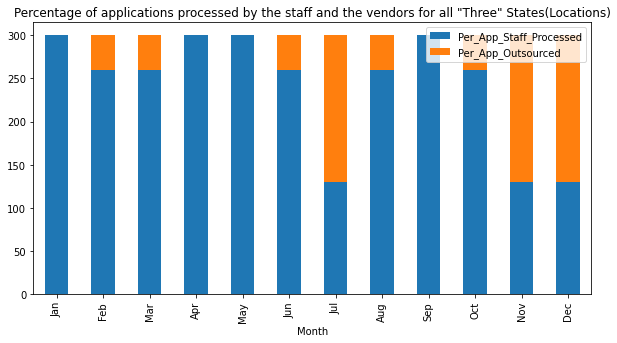

In [103]:
# plot data in stack manner of bar type
df_staff.plot( kind='bar', stacked=True, figsize=(10,5),
        title='Percentage of applications processed by the staff and the vendors for all "Three" States(Locations)')
plt.show()

#### Inference from above plot:
- Notice this plot has maximum of 300% and not 100% as 100% of all three states(locations) add up to 300%

### State Wise(Location Wise) stacked bar charts:

### State 'A' Charts:

In [104]:
FTE_StaffA=FTE_Staff[FTE_Staff.State=='A']
print(FTE_StaffA.shape)
FTE_StaffA.head(12)

(12, 13)


,State,Month,Apps_Demand,LB_Per,UB_Per,StaffAvPer,FTE,App_Outsourced,App_Staff_Processed,Per_App_Outsourced,Per_App_Staff_Processed,Monthly_Cost,Avg_Cost_Per_App
0,A,Jan,5240,0.70,0.90,0.81,161.728395,0.0,5240.0,0.00,100.00,808641.975309,154.320988
1,A,Feb,4878,0.65,0.85,0.76,160.460526,0.0,4878.0,0.00,100.00,802302.631579,164.473684
2,A,Mar,5942,0.70,0.80,0.75,198.066667,0.0,5942.0,0.00,100.00,990333.333333,166.666667
3,A,Apr,2297,0.75,0.85,0.80,71.781250,0.0,2297.0,0.00,100.00,358906.250000,156.250000
4,A,May,1992,0.70,0.85,0.78,63.846154,0.0,1992.0,0.00,100.00,319230.769231,160.256410
5,A,Jun,2275,0.65,0.80,0.73,77.910959,0.0,2275.0,0.00,100.00,389554.794521,171.232877
6,A,Jul,5334,0.60,0.75,0.68,137.279412,1600.0,3734.0,30.00,70.00,974397.058824,182.676614
7,A,Aug,3371,0.65,0.85,0.76,110.888158,0.0,3371.0,0.00,100.00,554440.789474,164.473684
8,A,Sep,3759,0.70,0.90,0.81,116.018519,0.0,3759.0,0.00,100.00,580092.592593,154.320988
9,A,Oct,3529,0.65,0.80,0.73,120.856164,0.0,3529.0,0.00,100.00,604280.821918,171.232877


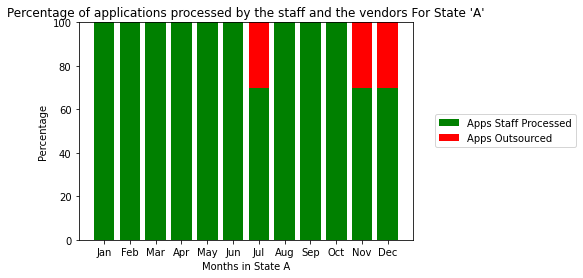

In [105]:
# One Method(Manual) to plot bars in stacked manner
plt.bar(FTE_StaffA.Month, FTE_StaffA.Per_App_Staff_Processed, color='g') #Green color for staff processed applications
plt.bar(FTE_StaffA.Month, FTE_StaffA.Per_App_Outsourced, bottom=FTE_StaffA.Per_App_Staff_Processed, color='r') #Red color for outsourced applications(red indicating danger and cost to company)
# changing the rc parameters(figure size)
plt.rcParams['figure.figsize'] = [10, 5]
plt.xlabel("Months in State A")
plt.ylabel("Percentage")
plt.legend(["Apps Staff Processed", "Apps Outsourced"], bbox_to_anchor = (1.05, 0.6)) #Place legend outside graph
plt.title("Percentage of applications processed by the staff and the vendors For State 'A'")
plt.show()

In [106]:
df_staffA=FTE_StaffA[['Month','Per_App_Staff_Processed','Per_App_Outsourced']] #The order you mention, the data gets stacked in that respective order
df_staffA.head(12)

,Month,Per_App_Staff_Processed,Per_App_Outsourced
0,Jan,100.00,0.00
1,Feb,100.00,0.00
2,Mar,100.00,0.00
3,Apr,100.00,0.00
4,May,100.00,0.00
5,Jun,100.00,0.00
6,Jul,70.00,30.00
7,Aug,100.00,0.00
8,Sep,100.00,0.00
9,Oct,100.00,0.00


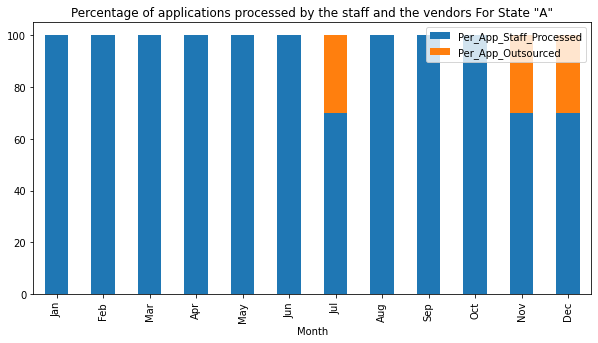

In [107]:
# plot data in stack manner of bar type
df_staffA.plot(x='Month', kind='bar', stacked=True, figsize=(10,5),
        title='Percentage of applications processed by the staff and the vendors For State "A"')
plt.show()

### State 'B' Charts:

In [108]:
FTE_StaffB=FTE_Staff[FTE_Staff.State=='B']
print(FTE_StaffB.shape)
FTE_StaffB.head(12)

(12, 13)


,State,Month,Apps_Demand,LB_Per,UB_Per,StaffAvPer,FTE,App_Outsourced,App_Staff_Processed,Per_App_Outsourced,Per_App_Staff_Processed,Monthly_Cost,Avg_Cost_Per_App
12,B,Jan,4927,0.70,0.90,0.81,152.067901,0.0,4927.0,0.00,100.00,696977.880658,141.460905
13,B,Feb,2628,0.65,0.85,0.76,51.875000,1051.0,1577.0,39.99,60.01,395410.416667,150.460585
14,B,Mar,2974,0.70,0.80,0.75,59.500000,1189.0,1785.0,39.98,60.02,451058.333333,151.667227
15,B,Apr,2338,0.75,0.85,0.80,73.062500,0.0,2338.0,0.00,100.00,334869.791667,143.229167
16,B,May,4020,0.70,0.85,0.78,128.846154,0.0,4020.0,0.00,100.00,590544.871795,146.901709
17,B,Jun,3147,0.65,0.80,0.73,64.691781,1258.0,1889.0,39.97,60.03,485203.995434,154.179852
18,B,Jul,4271,0.60,0.75,0.68,94.227941,1708.0,2563.0,39.99,60.01,688078.063725,161.104674
19,B,Aug,2620,0.65,0.85,0.76,51.710526,1048.0,1572.0,40.00,60.00,394206.578947,150.460526
20,B,Sep,4517,0.70,0.90,0.81,139.413580,0.0,4517.0,0.00,100.00,638978.909465,141.460905
21,B,Oct,4155,0.65,0.80,0.73,85.376712,1662.0,2493.0,40.00,60.00,640609.931507,154.178082


In [109]:
df_staffB=FTE_StaffB[['Month','Per_App_Staff_Processed','Per_App_Outsourced']] #The order you mention, the data gets stacked in that respective order
df_staffB.head(12)

,Month,Per_App_Staff_Processed,Per_App_Outsourced
12,Jan,100.00,0.00
13,Feb,60.01,39.99
14,Mar,60.02,39.98
15,Apr,100.00,0.00
16,May,100.00,0.00
17,Jun,60.03,39.97
18,Jul,60.01,39.99
19,Aug,60.00,40.00
20,Sep,100.00,0.00
21,Oct,60.00,40.00


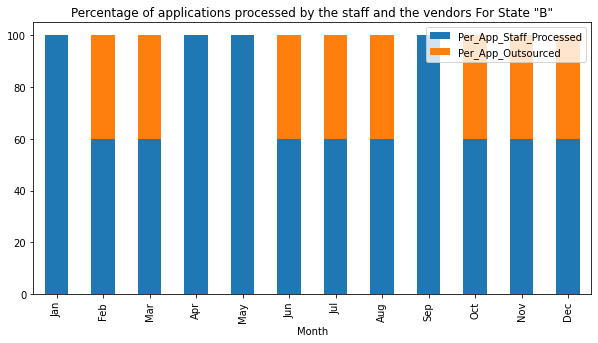

In [110]:
# plot data in stack manner of bar type
df_staffB.plot(x='Month', kind='bar', stacked=True, figsize=(10,5),
        title='Percentage of applications processed by the staff and the vendors For State "B"')
plt.show()

### State 'C' Charts:

In [111]:
FTE_StaffC=FTE_Staff[FTE_Staff.State=='C']
print(FTE_StaffC.shape)
FTE_StaffC.head(12)

(12, 13)


,State,Month,Apps_Demand,LB_Per,UB_Per,StaffAvPer,FTE,App_Outsourced,App_Staff_Processed,Per_App_Outsourced,Per_App_Staff_Processed,Monthly_Cost,Avg_Cost_Per_App
24,C,Jan,1162,0.70,0.90,0.81,35.864198,0.0,1162.0,0.0,100.0,158400.205761,136.316872
25,C,Feb,1967,0.65,0.85,0.76,64.703947,0.0,1967.0,0.0,100.0,285775.767544,145.285088
26,C,Mar,1898,0.70,0.80,0.75,63.266667,0.0,1898.0,0.0,100.0,279427.777778,147.222222
27,C,Apr,2261,0.75,0.85,0.80,70.656250,0.0,2261.0,0.0,100.0,312065.104167,138.020833
28,C,May,2030,0.70,0.85,0.78,65.064103,0.0,2030.0,0.0,100.0,287366.452991,141.559829
29,C,Jun,1642,0.65,0.80,0.73,56.232877,0.0,1642.0,0.0,100.0,248361.872146,151.255708
30,C,Jul,2489,0.60,0.75,0.68,0.000000,2489.0,0.0,100.0,0.0,398240.000000,160.000000
31,C,Aug,2496,0.65,0.85,0.76,82.105263,0.0,2496.0,0.0,100.0,362631.578947,145.285088
32,C,Sep,922,0.70,0.90,0.81,28.456790,0.0,922.0,0.0,100.0,125684.156379,136.316872
33,C,Oct,2421,0.65,0.80,0.73,82.910959,0.0,2421.0,0.0,100.0,366190.068493,151.255708


In [112]:
df_staffC=FTE_StaffC[['Month','Per_App_Staff_Processed','Per_App_Outsourced']] #The order you mention, the data gets stacked in that respective order
df_staffC.head(12)

,Month,Per_App_Staff_Processed,Per_App_Outsourced
24,Jan,100.0,0.0
25,Feb,100.0,0.0
26,Mar,100.0,0.0
27,Apr,100.0,0.0
28,May,100.0,0.0
29,Jun,100.0,0.0
30,Jul,0.0,100.0
31,Aug,100.0,0.0
32,Sep,100.0,0.0
33,Oct,100.0,0.0


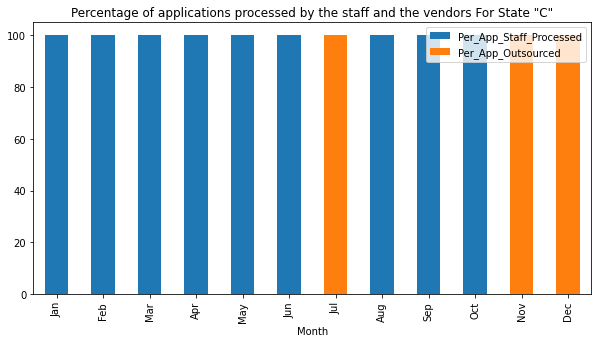

In [113]:
# plot data in stack manner of bar type
df_staffC.plot(x='Month', kind='bar', stacked=True, figsize=(10,5),
        title='Percentage of applications processed by the staff and the vendors For State "C"')
plt.show()

---

#### Create a graph to show how the cost per application increases with respect to any change in the parameters in your analysis. (Hint: Use the cost per application that you calculate in Questions 2 and 3, i.e., the actual scenario, best case, and worst case.)

In [114]:
FTE_Staff.head(1)

,State,Month,Apps_Demand,LB_Per,UB_Per,StaffAvPer,FTE,App_Outsourced,App_Staff_Processed,Per_App_Outsourced,Per_App_Staff_Processed,Monthly_Cost,Avg_Cost_Per_App
0,A,Jan,5240,0.7,0.9,0.81,161.728395,0.0,5240.0,0.0,100.0,808641.975309,154.320988


In [115]:
df_staff_actual = FTE_Staff[['Month','Monthly_Cost','Avg_Cost_Per_App']]
df_staff_actual.rename(columns = {'Monthly_Cost':'Monthly_Cost_Actual', 'Avg_Cost_Per_App':'Avg_Cost_Per_App_Actual'}, inplace = True)
df_staff_WC = FTE_Staff_WC[['Monthly_Cost','Avg_Cost_Per_App']]
df_staff_WC.rename(columns = {'Monthly_Cost':'Monthly_Cost_WC', 'Avg_Cost_Per_App':'Avg_Cost_Per_App_WC'}, inplace = True)
df_staff_BC = FTE_Staff_BC[['Monthly_Cost','Avg_Cost_Per_App']]
df_staff_BC.rename(columns = {'Monthly_Cost':'Monthly_Cost_BC', 'Avg_Cost_Per_App':'Avg_Cost_Per_App_BC'}, inplace = True)

# concatenating dataframes along columns
df_staff_all = pd.concat([df_staff_actual, df_staff_WC,df_staff_BC], axis=1)
df_staff_all['Month_num'] = df_staff_all.Month.map(d)
df_staff_all.head(2)

D:\dev\anaconda_installation_folder\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,Month,Monthly_Cost_Actual,Avg_Cost_Per_App_Actual,Monthly_Cost_WC,Avg_Cost_Per_App_WC,Monthly_Cost_BC,Avg_Cost_Per_App_BC,Month_num
0,Jan,808641.975309,154.320988,935714.285714,178.571429,727777.777778,138.888889,1
1,Feb,802302.631579,164.473684,920070.769231,188.616394,717352.941176,147.058824,2


In [116]:
df_staff_all_costperapp= df_staff_all[['Month','Month_num','Avg_Cost_Per_App_WC','Avg_Cost_Per_App_Actual','Avg_Cost_Per_App_BC']]
df_staff_all_costperapp.head(1)

,Month,Month_num,Avg_Cost_Per_App_WC,Avg_Cost_Per_App_Actual,Avg_Cost_Per_App_BC
0,Jan,1,178.571429,154.320988,138.888889


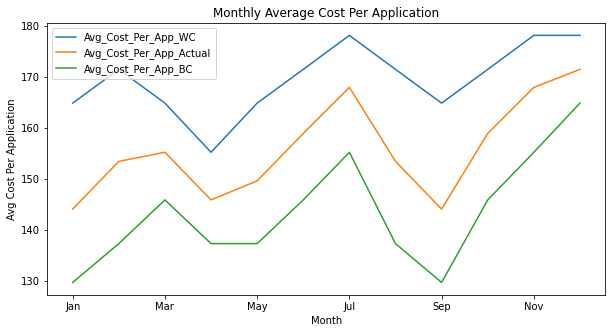

In [117]:
df_staff_all_costperapp = df_staff_all_costperapp.groupby(['Month']).mean().sort_values("Month_num",ascending=True)
df_staff_all_costperapp.drop(['Month_num'], axis = 1, inplace = True) #drop 'month_num' after you have used it for sorting months.
df_staff_all_costperapp.plot.line(figsize=[10,5])
plt.xlabel("Month")
plt.ylabel("Avg Cost Per Application")
plt.title("Monthly Average Cost Per Application")
plt.show()

#### Inference from above plot: 
- You can see that the WC(worst Case Line) is way above and leads in cost, than comes Actual and than comes BC(Best Case) line which is least in cost
- We can infer from below graph that the cost/app is high during the month of March, July and also increases towards the end of year in months of November and December.

#### Only the above graph is asked in the assignment, however if needed we can plot the graph for "Monthly_Cost" for all applications processed in a particular month as shown below:

In [118]:
df_staff_all_monthlycost= df_staff_all[['Month','Month_num','Monthly_Cost_WC','Monthly_Cost_Actual','Monthly_Cost_BC']]
df_staff_all_monthlycost.head(1)

,Month,Month_num,Monthly_Cost_WC,Monthly_Cost_Actual,Monthly_Cost_BC
0,Jan,1,935714.285714,808641.975309,727777.777778


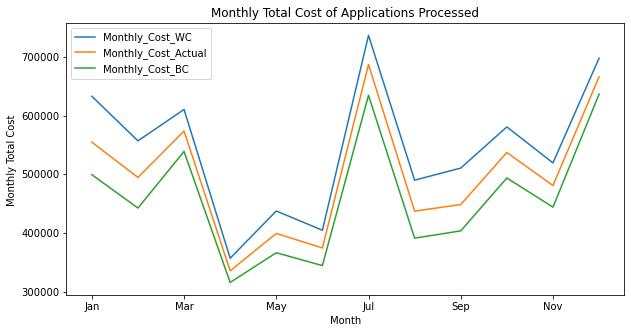

In [119]:
df_staff_all_monthlycost = df_staff_all_monthlycost.groupby(['Month']).mean().sort_values("Month_num",ascending=True)
df_staff_all_monthlycost.drop(['Month_num'], axis = 1, inplace = True) #drop 'month_num' after you have used it for sorting months.
df_staff_all_monthlycost.plot.line(figsize=[10,5])
plt.xlabel("Month")
plt.ylabel("Monthly Total Cost ")
plt.title("Monthly Total Cost of Applications Processed")
plt.show()

#### Inference from above plot/graph:
- We can infer from below graph that the “Total Monthly Cost” is high during the month of March, July and also increases towards the end of year in months of November and December

# This Staff Planning assignment is submitted by Achal Kagwad and Himanka Das of DSC26 Batch on 25th October 2021

# Thank you Upgrad and IIITB For the Learning Experience!

#### Project Complete
- This Project is done by `Achal Kagwad`
- Contact no: +91-9108302174
- Email Id: achal.kagwad@gmail.com
- Linked in: https://www.linkedin.com/in/achalkagwad/

---